In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [17]:
%pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Ug8A6Sdpncu1HNsGIV41")
project = rf.workspace("chess-project").project("2d-chessboard-and-chess-pieces")
dataset = project.version(4).download("tensorflow")


Note: you may need to restart the kernel to use updated packages.
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to 2D-Chessboard-and-Chess-Pieces-4 in tensorflow:: 100%|██████████| 5008/5008 [00:05<00:00, 929.23it/s] 


In [11]:
# import random

# random.seed(48198)
# print(random.randint(1, 500))

# training_data_path = './2D-Chessboard-and-Chess-Pieces-4/train/'
# testing_data_path = './2D-Chessboard-and-Chess-Pieces-4/test/'
# validation_data_path = './2D-Chessboard-and-Chess-Pieces-4/valid/'

# training_annotations = pd.read_csv('2D-Chessboard-and-Chess-Pieces-4/train/_annotations.csv')
# testing_annotations = pd.read_csv('./2D-Chessboard-and-Chess-Pieces-4/test/_annotations.csv')

# temp_path = training_annotations["filename"][random.randint(1, 500)]

# training_dir = os.path.join(training_data_path, temp_path)
# training_dir
# img = cv2.imread(training_dir)
# imgplot = plt.imshow(img)
# plt.show()
# print(training_dir)

In [12]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose([
    transforms.ToTensor()
    ])


# download and load training dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=1)

## download and load testing dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=1)

100%|██████████| 9912422/9912422 [00:03<00:00, 3071157.69it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 70776.59it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5672850.68it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [13]:
print('Training Dataset: \n', train_dataset)
print('\nTest Dataset: \n', test_dataset)

Training Dataset: 
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Test Dataset: 
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


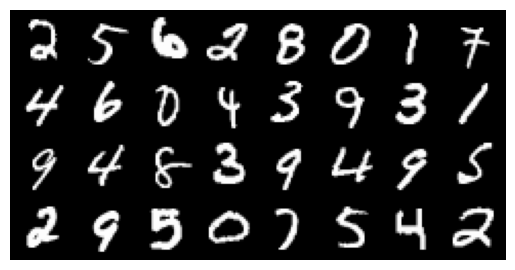

In [16]:
import matplotlib.pyplot as plt
import numpy as np

## get some random training images
images, labels = next(iter(train_loader))

## show images
images_grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(images_grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [ ]:
for images, labels in train_loader:
    print("Train - image batch dimensions:", images.shape)
    print("Train - image label dimensions:", labels.shape)
    break

for images, labels in test_loader:
    print("Test - image batch dimensions:", images.shape)
    print("Test - image label dimensions:", labels.shape)
    break

Train - image batch dimensions: torch.Size([32, 1, 28, 28])
Train - image label dimensions: torch.Size([32])
Test - image batch dimensions: torch.Size([32, 1, 28, 28])
Test - image label dimensions: torch.Size([32])


In [ ]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.conv_layer = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.fc_layer1 = nn.Linear(26 * 26 * 32, 128)
        self.fc_layer2 = nn.Linear(128, 10)

    def forward(self, x):
        # input: 32x1x28x28 -> output: 32x32x26x26
        x = self.conv_layer(x)
        x = F.relu(x)

        # input: 32x32x26x26 -> output: 32x(32*26*26)
        x = x.flatten(start_dim = 1)

        # input: 32x(32*26*26) -> output: 32x128
        x = self.fc_layer1(x)
        x = F.relu(x)

        # input: 32x128 -> output: 32x10 (32 images, 10 classes)
        x = self.fc_layer2(x)
        out = F.softmax(x, dim=1)
        return out

In [ ]:
model = SimpleModel()
for images, labels in train_loader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [ ]:
def train_model(model, loss_fn, optimizer, data_loader, num_epochs, device):

  for epoch in range(num_epochs):
    train_loss = 0.0
    train_corr, train_n = 0, 0

    model.train()
    for i, (images, labels) in enumerate(data_loader):
        
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()     # zero the gradients (by default it adds up)

      ## forward + backprop + loss
      outputs = model(images)
      loss = loss_fn(outputs, labels)
      loss.backward()

      ## update model params
      optimizer.step()

      _, preds = torch.max(outputs, 1)
      train_corr += torch.sum(preds == labels).item()
      train_n += labels.size(0)

      train_loss += loss.item()
    
    print('Epoch: %d | Loss: %.4f | Train Acc: %.2f%%' \
          %(epoch, train_loss / i, train_corr / train_n * 100))
      
  return model

In [ ]:
learning_rate = 0.005
num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleModel()
model = model.to(device)

## loss function
loss_fn = nn.CrossEntropyLoss()
## optimization
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

device

device(type='cuda')

In [ ]:
model = train_model(model, loss_fn, optimizer, train_loader, num_epochs, device)

Epoch: 0 | Loss: 1.6382 | Train Acc: 84.80%
Epoch: 1 | Loss: 1.5353 | Train Acc: 93.11%
Epoch: 2 | Loss: 1.5176 | Train Acc: 94.78%
Epoch: 3 | Loss: 1.5074 | Train Acc: 95.70%
Epoch: 4 | Loss: 1.5002 | Train Acc: 96.42%


In [ ]:
def test_model(model, data_loader):
  model.eval()         # Set the model to evaluation mode

  correct = 0
  n = 0
  with torch.no_grad():   # disable gradient calculation, reduce memory usage 
    for i, (images, labels) in enumerate(data_loader):
        
      images = images.to(device)
      labels = labels.to(device)

      # zero the gradients
      optimizer.zero_grad()

      output = model(images)
      _, pred = torch.max(output, 1)

      correct += torch.sum(pred == labels).item()
      n += labels.size(0)

  acc = correct / n

  return acc

In [ ]:
acc_ts = test_model(model, test_loader)

print('Test Accuracy: %.2f'%( acc_ts * 100))

Test Accuracy: 95.62


In [ ]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleModel()
model = model.to(device)

## loss function
loss_fn = nn.CrossEntropyLoss()
## optimization
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

In [ ]:
model = train_model(model, loss_fn, optimizer, train_loader, num_epochs, device)

acc_ts = test_model(model, test_loader)

print('Test Accuracy: %.2f'%( acc_ts * 100))

Epoch: 0 | Loss: 1.6214 | Train Acc: 84.40%
Epoch: 1 | Loss: 1.4916 | Train Acc: 97.22%
Epoch: 2 | Loss: 1.4823 | Train Acc: 98.11%
Epoch: 3 | Loss: 1.4782 | Train Acc: 98.47%
Epoch: 4 | Loss: 1.4750 | Train Acc: 98.74%
Test Accuracy: 97.93
